# Data processing


Import Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
import copy

## load data

In [4]:
(x_train, y_train), (x_test,y_test)= tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


## change dimension & normalization

In [6]:
#change the dimension of input array, from 3D to 2D
def dimension_reduction(data):
  result=[]
  
  for pixel in data:
    image_ary = pixel.flatten()
    image_ary = image_ary.astype(np.float32)
    result.append(image_ary)
  
  result=np.asarray(result)

  return result

In [7]:
x_train_2d = dimension_reduction(x_train)

x_train_origin = copy.deepcopy(x_train_2d) # unnormalization x_train set for task 3.4

x_train_2d /= 255  # normalization

x_train_2d = x_train_2d.reshape(x_train_2d.shape[0], x_train_2d.shape[1], 1)

x_test_2d = dimension_reduction(x_test)

x_test_origin = copy.deepcopy(x_test_2d) # unnormalization x_test set for task 3.4

x_test_2d /= 255  # normalization

x_test_2d = x_test_2d.reshape(x_test_2d.shape[0], x_test_2d.shape[1], 1)


#reshape for CNN
x_train_cnn = x_train/255
x_test_cnn = x_test/255

#convet the y label to 1xN array
label = LabelBinarizer()
y_train_hor = label.fit_transform(y_train)
y_test_hor = label.transform(y_test)


In [8]:
print(x_train_2d.shape)
print(x_test_2d.shape)

num_train, num_test = x_train.shape[0], x_test.shape[0]
x_train_mlp = x_train.reshape(num_train, -1)    # vectorization
x_test_mlp = x_test.reshape(num_test, -1)
x_train_mlp = x_train_mlp.astype('float32')/255.0  # normalization to the range [0, 1] 
x_test_mlp = x_test_mlp.astype('float32')/255.0

print(x_train_mlp.shape)
print(x_test_mlp.shape)

(60000, 784, 1)
(10000, 784, 1)
(60000, 784)
(10000, 784)


In [9]:
#one-hot-coding of y for MLP
y_train_after = np.zeros((y_train.size, 10))
for i, row in enumerate(y_train_after):
    row[y_train[i]] = 1
#y_train_after = y_train_after.reshape(y_train_after.shape[0], y_train_after.shape[1], 1)

y_test_after = np.zeros((y_test.size, 10))
for i, row in enumerate(y_test_after):
    row[y_test[i]] = 1
#y_test_after = y_test_after.reshape(y_test_after.shape[0], y_test_after.shape[1], 1) 

print(y_train_after.shape)

(60000, 10)


## visualize the dataset

Text(0, 0.5, 'Frequency')

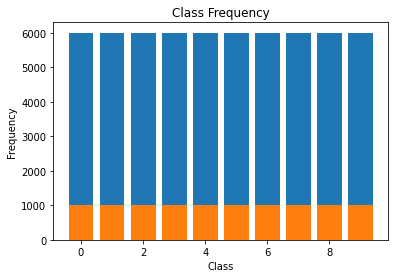

In [10]:

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
unique, counts = np.unique(y_test, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

# MLP

In [11]:
# activation function and its derivative
relu = lambda z: np.maximum(0,z)
drelu = lambda z: (z>0).astype(float)
tanh = lambda z: (np.exp(z)-np.exp(-z)) / (np.exp(z)+np.exp(-z))
dtanh = lambda z: 1 - np.power(tanh(z), 2)
leaky = lambda z: np.maximum(z*0.01, z)
dleaky = lambda z: np.maximum(z*0.01, z) / z

# softmax
def softmax(x):
    e = np.exp(x - np.max(x))
    return  e / e.sum()

import torch
import torch.nn as nn
loss_fn = nn.CrossEntropyLoss()

In [12]:
import math
class BatchGenerator:

    def __init__(self, images, labels, batch_size):
        assert len(images) == len(labels)
        self.index = 0
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(images) / batch_size)


    def next(self):
        images = self.images[self.index : self.index + self.batch_size]
        labels = self.labels[self.index : self.index + self.batch_size]
        self.index += self.batch_size
        return images, labels

In [21]:

class MLP:
    
    def __init__(self, act, dact, nhid, hid_size, lr, dropout):
        self.act = act #activation function
        self.dact = dact #derivative of activation
        self.hid_num = nhid # scalar num layers
        self.layer = nhid+1
        self.hid_size = hid_size # nhid array containing hidden unit size at each layer
        self.learning_rate = lr
        self.dropout = dropout
        
        # all lists below have length self.layer
        self.W = list()       # list of weights matrix
        self.B = list()       # list of bias vector
        self.Z = list()       # list of hidden units
        self.dZ = list()      # list of derivative of hidden units
        self.delta = list()   # list of errors


    # forward calculation for a batch
    def forward_propagate(self, xi):
        '''
         Inputs: xi: N*C batch
                 d_act: derivative of activation function

         For each layer we update lists Z and dZ: 
         q = W[l] * Z[l-1] + B[l]
         Z[l] = act(q)
         dZ[l] = d_act(q)
         
        '''
        # first hidden layer
        if (self.layer >1):
          q1 = np.dot(xi, self.W[0]) + self.B[0]
          mask = (np.random.rand(*q1.shape) < (1 - self.dropout)) / (1 - self.dropout)
          cache = (mask, self.dropout) 
          q = q1 * mask
          q.reshape(q1.shape)
          z = self.act(q)
          self.Z.append(z)
          self.dZ.append(self.dact(q))

        # other hidden layers
        for i in range(1, self.layer-1):
          q1 = np.dot(self.Z[i-1], self.W[i]) + self.B[i]
          mask = (np.random.rand(*q1.shape) < (1 - self.dropout)) / (1 - self.dropout)
          cache = (mask, self.dropout) 
          q = q1 * mask
          q.reshape(q1.shape)
          # print(q1.shape)
          # print(q.shape)
          # for j in range (0, q.shape[0]):
          #   s = np.random.binomial(1, 0.1)
          #   if s == 1:
          #     q[j] = q1[j]
         
          # q = np.dot(self.Z[i-1], self.W[i]) + self.B[i]
          z = self.act(q)
          self.Z.append(z)       
          self.dZ.append(self.dact(q))

        # output layer with softmax activation
        if (self.layer == 1):
          q = np.dot(xi, self.W[0]) + self.B[0]
          yh = np.array([softmax(qi) for qi in q])     
          self.Z.append(yh)
          self.dZ.append(np.zeros_like(yh))
        else:
          q = np.dot(self.Z[-1], self.W[-1]) + self.B[-1]
          cache = [1,0]
          yh = np.array([softmax(qi) for qi in q])     
          self.Z.append(yh)
          self.dZ.append(np.zeros_like(yh))

        #print(len(self.Z), len(self.dZ))
        assert len(self.Z) == len(self.dZ) == self.layer
        return cache

    
    def back_propagate(self, xi, yi, cache):
        '''
        For each layer we update the errors:
        delta[l] = (delta[l+1] dot W[l+1].T) * dZ[l]

        '''
        # Error in the output layer is dy*d(softmax) = y_hat-y
        error = self.Z[-1] - yi  # N*C
        self.delta.insert(0, error) 
        mask, p = cache 

        # hidden layers 
        for l in reversed(range(self.layer-1)):
          error = np.dot(self.delta[0], self.W[l+1].T)*(self.dZ[l]) # N*M
          if l == self.layer-2:
            error = error * mask
          self.delta.insert(0, error)

        assert len(self.delta) == self.layer


    def gradient(self, xi, yi):
        batch_size = xi.shape[1]
        dW = list(self.W)
        dB = list(self.B)

        dW[0] = np.dot(xi.T, self.delta[0]) / batch_size
        dB[0] = np.sum(self.delta[0], axis=0) / batch_size

        for l in range(1,self.layer):
          dW[l] = np.dot(self.Z[l-1].T, self.delta[l]) / batch_size
          dB[l] = np.sum(self.delta[l], axis=0) / batch_size

        return dW, dB


    def one_training(self, xi, yi):
        self.Z = list()       
        self.dZ = list()      
        self.delta = list()   

        cache = self.forward_propagate(xi)
        self.back_propagate(xi, yi, cache)

        dW, dB = self.gradient(xi, yi)
        W, B = self.W.copy(), self.B.copy()
        for i in range(len(W)):
            W[i] -= self.learning_rate * dW[i]
            B[i] -= self.learning_rate * dB[i]
        
        self.W, self.B = W, B


    def fit(self, x, y, epoch=30, threshold=0.005, batch_size=128):
        N,D = x.shape
        C  = y.shape[1]

        # initialize parameters
        self.W = list()
        self.B = list()
        self.W.append(np.random.randn(D, self.hid_size[0]) * .01)
        self.B.append(np.zeros(self.hid_size[0]))   

        for i in range(1,self.layer-1):
          self.W.append(np.random.randn(self.hid_size[i-1], self.hid_size[i]) * .01)
          self.B.append(np.zeros(self.hid_size[i]))

        if (self.layer >1):
          self.W.append(np.random.randn(self.hid_size[-1], C) * .01)
          self.B.append(np.zeros(C))
  
        assert len(self.W) == len(self.B) == self.layer

        # training
        cost_list = list()
        for epoch_counter in range(epoch):
          cost = 0
          batch_generator = BatchGenerator(x, y, batch_size)

          for batch_counter in range(batch_generator.num_batches):
              x_batch, y_batch = batch_generator.next()
              self.one_training(x_batch, y_batch)
              yh = self.Z[-1]
              assert yh.shape == y_batch.shape

              loss = loss_fn(torch.tensor(yh), torch.tensor(y_batch))
              cost += loss
          cost = cost/batch_generator.num_batches
          print(f"cost after epoch {epoch_counter}: {cost:.3f}")
          

          if epoch_counter > 5 and abs(cost-cost_list[-1]) < threshold:
              break
          cost_list.append(cost)

        return cost
    

    def predict(self,x):
        self.Z = list()       
        self.dZ = list()      
        self.forward_propagate(x)
        return self.Z[-1]

    def evaluate_acc(self, y_pred, y):
      if y.shape[1] != 1:
        y = np.argmax(y, axis=1)
      if y_pred.shape[1] != 1:
        y_pred = np.argmax(y_pred, axis=1)
      matches = y_pred == y
      accuracy = matches.mean()
      
      return accuracy

    

# Experiment

## 3.1 Impact of depth

In [22]:
# MLP with a single hidden layer having 128 units and ReLU activations
mlp1 = MLP(relu, drelu, 1, [128], 1.3, 0)
mlp1.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp1.predict(x_test_mlp)
acc = mlp1.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc:.3f}")

cost after epoch 0: 1.807
cost after epoch 1: 1.686
cost after epoch 2: 1.661
cost after epoch 3: 1.647
cost after epoch 4: 1.638
cost after epoch 5: 1.631
cost after epoch 6: 1.625
cost after epoch 7: 1.620
cost after epoch 8: 1.615
cost after epoch 9: 1.611
cost after epoch 10: 1.608
cost after epoch 11: 1.604
cost after epoch 12: 1.601
cost after epoch 13: 1.598
cost after epoch 14: 1.595
cost after epoch 15: 1.593
cost after epoch 16: 1.590
cost after epoch 17: 1.588
cost after epoch 18: 1.585
cost after epoch 19: 1.583
cost after epoch 20: 1.581
cost after epoch 21: 1.579
cost after epoch 22: 1.577
cost after epoch 23: 1.575
cost after epoch 24: 1.573
test accuracy: 0.888


In [29]:
# MLP with 2 hidden layers each having 128 units with ReLU activations.
mlp2 = MLP(relu, drelu, 2, [128,80], 1.7, 0)
mlp2.fit(x_train_mlp, y_train_after, epoch=20, threshold=0.0001, batch_size=128)
pred = mlp2.predict(x_test_mlp)
acc = mlp2.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc:.3f}")

cost after epoch 0: 1.939
cost after epoch 1: 1.708
cost after epoch 2: 1.668
cost after epoch 3: 1.650
cost after epoch 4: 1.639
cost after epoch 5: 1.630
cost after epoch 6: 1.622
cost after epoch 7: 1.616
cost after epoch 8: 1.611
cost after epoch 9: 1.606
cost after epoch 10: 1.602
cost after epoch 11: 1.598
cost after epoch 12: 1.594
cost after epoch 13: 1.591
cost after epoch 14: 1.588
cost after epoch 15: 1.584
cost after epoch 16: 1.582
cost after epoch 17: 1.579
cost after epoch 18: 1.576
cost after epoch 19: 1.575
test accuracy: 0.883


In [ ]:
learning=[0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9]

acc1=[]
acc2=[]
acc3=[]

for hyper in learning:
  mlp0 = MLP(None, None, 0, [10], hyper, 0)
  mlp0.fit(x_train_mlp, y_train_after)
  pred = mlp0.predict(x_test_mlp)
  acc1.append(mlp0.evaluate_acc(pred, y_test_after))


  mlp1 = MLP(relu, drelu, 1, [128], hyper, 0)
  mlp1.fit(x_train_mlp, y_train_after)
  pred = mlp1.predict(x_test_mlp)
  acc2.append(mlp1.evaluate_acc(pred, y_test_after))

  mlp2 = MLP(relu, drelu, 2, [128,128], hyper, 0)
  mlp2.fit(x_train_mlp, y_train_after)
  pred = mlp2.predict(x_test_mlp)
  acc3.append(mlp2.evaluate_acc(pred, y_test_after)) 

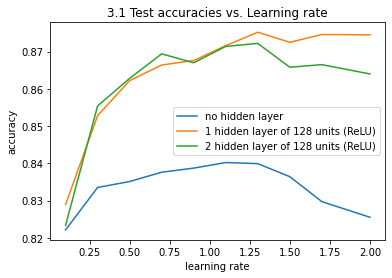

In [ ]:
x=learning
plt.title("3.1 Test accuracies vs. Learning rate")
plt.plot(x,acc1, '-', label="no hidden layer")
plt.plot(x,acc2,'-', label="1 hidden layer of 128 units (ReLU)")
plt.plot(x,acc3, '-', label="2 hidden layer of 128 units (ReLU)")
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.show()

In [ ]:
epoch_list = [5,10,15,20,25,30,35]

acc11=[]
acc21=[]
acc31=[]
mlp0 = MLP(None, None, 0, [10], 1.3, 0)
mlp1 = MLP(relu, drelu, 1, [128], 1.3, 0)
mlp2 = MLP(relu, drelu, 2, [128,128], 1.3, 0)

for hyper in epoch_list:
  mlp0.fit(x_train_mlp, y_train_after, epoch = hyper, threshold=0.0001)
  pred = mlp0.predict(x_test_mlp)
  acc11.append(mlp0.evaluate_acc(pred, y_test_after))

  mlp1.fit(x_train_mlp, y_train_after, epoch = hyper, threshold=0.0001)
  pred = mlp1.predict(x_test_mlp)
  acc21.append(mlp1.evaluate_acc(pred, y_test_after))

  mlp2.fit(x_train_mlp, y_train_after, epoch = hyper, threshold=0.0001)
  pred = mlp2.predict(x_test_mlp)
  acc31.append(mlp2.evaluate_acc(pred, y_test_after)) 

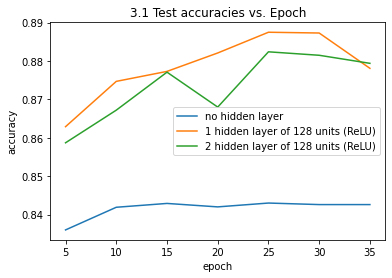

In [ ]:
x=epoch_list
plt.title("3.1 Test accuracies vs. Epoch")
plt.plot(x,acc11, '-', label="no hidden layer")
plt.plot(x,acc21,'-', label="1 hidden layer of 128 units (ReLU)")
plt.plot(x,acc31, '-', label="2 hidden layer of 128 units (ReLU)")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 3.2 Impact of activation functions

In [ ]:
#3.2
acc4=[]
acc5=[]
for hyper in learning:  
  mlp_tanh = MLP(tanh, dtanh, 2, [128,128], hyper, 0)
  mlp_tanh.fit(x_train_mlp, y_train_after)
  pred4 = mlp_tanh.predict(x_test_mlp)
  acc4.append(mlp_tanh.evaluate_acc(pred4, y_test_after))

  mlp_leaky = MLP(leaky, dleaky, 2, [128,128], hyper, 0)
  mlp_leaky.fit(x_train_mlp, y_train_after)
  pred5 = mlp_leaky.predict(x_test_mlp)
  acc5.append(mlp_tanh.evaluate_acc(pred5, y_test_after))

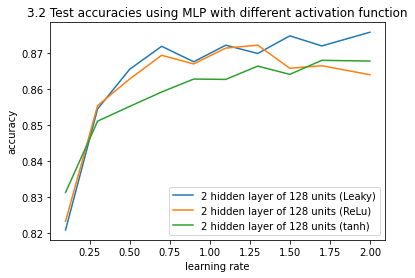

In [ ]:
x=learning
plt.title("3.2 Test accuracies using MLP with different activation function")
plt.plot(x,acc5, '-', label="Leaky-ReLU")
plt.plot(x,acc3,'-', label="ReLu")
plt.plot(x,acc4,'-', label="tanh")
plt.legend()
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.show()

In [ ]:
epoch_list = [5,10,15,20,25,30,35]

acc41=[]
acc51=[]

mlp_tanh = MLP(tanh, dtanh, 2, [128,128], 2)
mlp_leaky = MLP(leaky, dleaky, 2, [128,128], 2)

for hyper in epoch_list:
  mlp_tanh.fit(x_train_mlp, y_train_after, epoch = hyper, threshold=0.0001)
  pred = mlp_tanh.predict(x_test_mlp)
  acc41.append(mlp_tanh.evaluate_acc(pred, y_test_after))

  mlp_leaky.fit(x_train_mlp, y_train_after, epoch = hyper, threshold=0.0001)
  pred = mlp_leaky.predict(x_test_mlp)
  acc51.append(mlp_leaky.evaluate_acc(pred, y_test_after))
 

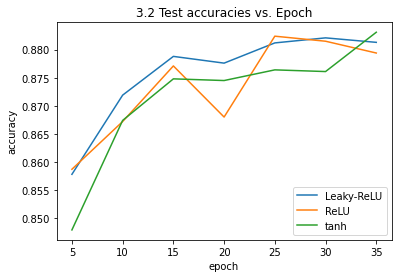

In [ ]:
x=epoch_list

plt.title("3.2 Test accuracies vs. Epoch")
plt.plot(x,acc51, '-', label="Leaky-ReLU")
plt.plot(x,acc31, '-', label="ReLU")
plt.plot(x,acc41,'-', label="tanh")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## 3.3 add dropout

In [13]:
# MLP with 2 hidden layers each having 128 units with ReLU activations with dropout.
mlp2 = MLP(relu, drelu, 2, [128,128], 1.3, 0)
mlp2.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp2.predict(x_test_mlp)
acc1 = mlp2.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc1:.2f}")

mlp2 = MLP(relu, drelu, 2, [128,128], 1.3, 0.3)
mlp2.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp2.predict(x_test_mlp)
acc2 = mlp2.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc2:.2f}")

mlp2 = MLP(relu, drelu, 2, [128,128], 1.3, 0.6)
mlp2.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp2.predict(x_test_mlp)
acc3 = mlp2.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc3:.2f}")

mlp2 = MLP(relu, drelu, 2, [128,128], 1.3, 0.9)
mlp2.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp2.predict(x_test_mlp)
acc4 = mlp2.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc4:.2f}")

cost after epoch 0: 1.972
cost after epoch 1: 1.719
cost after epoch 2: 1.673
cost after epoch 3: 1.653
cost after epoch 4: 1.640
cost after epoch 5: 1.631
cost after epoch 6: 1.624
cost after epoch 7: 1.618
cost after epoch 8: 1.613
cost after epoch 9: 1.609
cost after epoch 10: 1.605
cost after epoch 11: 1.601
cost after epoch 12: 1.597
cost after epoch 13: 1.594
cost after epoch 14: 1.590
cost after epoch 15: 1.587
cost after epoch 16: 1.585
cost after epoch 17: 1.581
cost after epoch 18: 1.579
cost after epoch 19: 1.577
cost after epoch 20: 1.574
cost after epoch 21: 1.571
cost after epoch 22: 1.569
cost after epoch 23: 1.567
cost after epoch 24: 1.569
test accuracy: 0.88
cost after epoch 0: 1.975
cost after epoch 1: 1.736
cost after epoch 2: 1.687
cost after epoch 3: 1.665
cost after epoch 4: 1.651
cost after epoch 5: 1.641
cost after epoch 6: 1.634
cost after epoch 7: 1.628
cost after epoch 8: 1.622
cost after epoch 9: 1.618
cost after epoch 10: 1.614
cost after epoch 11: 1.610
c

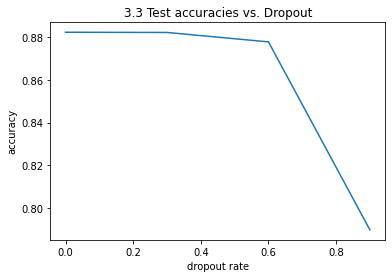

In [16]:
x=[0,0.3,0.6,0.9]
y=[acc1, acc2, acc3, acc4]
plt.title("3.3 Test accuracies vs. Dropout")
plt.plot(x, y)
plt.xlabel('dropout rate')
plt.ylabel('accuracy')
plt.show()

In [ ]:
epoch_list = [5,10,20,25,35]

acc41=[]
acc42=[]
acc43=[]
acc44=[]

mlp31 = MLP(relu, drelu, 2, [128,128], 1.3, 0)
mlp32 = MLP(relu, drelu, 2, [128,128], 1.3, 0.3)
mlp33 = MLP(relu, drelu, 2, [128,128], 1.3, 0.6)
mlp34 = MLP(relu, drelu, 2, [128,128], 1.3, 0.9)

for hyper in epoch_list:
  mlp31.fit(x_train_mlp, y_train_after, epoch=hyper, threshold=0.0001)
  pred = mlp31.predict(x_test_mlp)
  acc41.append(mlp31.evaluate_acc(pred, y_test_after))

  mlp32.fit(x_train_mlp, y_train_after, epoch=hyper, threshold=0.0001)
  pred = mlp32.predict(x_test_mlp)
  acc42.append(mlp32.evaluate_acc(pred, y_test_after))

  mlp33.fit(x_train_mlp, y_train_after, epoch=hyper, threshold=0.0001)
  pred = mlp33.predict(x_test_mlp)
  acc43.append(mlp33.evaluate_acc(pred, y_test_after))

  mlp34.fit(x_train_mlp, y_train_after, epoch=hyper, threshold=0.0001)
  pred = mlp34.predict(x_test_mlp)
  acc44.append(mlp34.evaluate_acc(pred, y_test_after))

cost after epoch 0: 1.971
cost after epoch 1: 1.715
cost after epoch 2: 1.670
cost after epoch 3: 1.651
cost after epoch 4: 1.639
cost after epoch 0: 2.020
cost after epoch 1: 1.783
cost after epoch 2: 1.729
cost after epoch 3: 1.703
cost after epoch 4: 1.688
cost after epoch 0: 2.093
cost after epoch 1: 1.922
cost after epoch 2: 1.864
cost after epoch 3: 1.831
cost after epoch 4: 1.808
cost after epoch 0: 2.238
cost after epoch 1: 2.185
cost after epoch 2: 2.163
cost after epoch 3: 2.152
cost after epoch 4: 2.149
cost after epoch 0: 1.975
cost after epoch 1: 1.715
cost after epoch 2: 1.670
cost after epoch 3: 1.652
cost after epoch 4: 1.640
cost after epoch 5: 1.631
cost after epoch 6: 1.625
cost after epoch 7: 1.618
cost after epoch 8: 1.613
cost after epoch 9: 1.608
cost after epoch 0: 2.009
cost after epoch 1: 1.780
cost after epoch 2: 1.725
cost after epoch 3: 1.701
cost after epoch 4: 1.684
cost after epoch 5: 1.672
cost after epoch 6: 1.663
cost after epoch 7: 1.658
cost after e

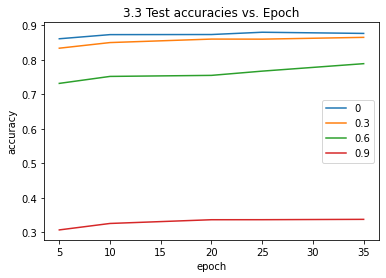

In [ ]:
x=epoch_list

plt.title("3.3 Test accuracies vs. Epoch")
plt.plot(x,acc41, '-', label="0")
plt.plot(x,acc42, '-', label="0.3")
plt.plot(x,acc43,'-', label="0.6")
plt.plot(x,acc44,'-', label="0.9")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

##3.4 Unnormalized

In [ ]:
# MLP with 2 hidden layers each having 128 units with ReLU activations using unnormalized data
mlp2 = MLP(relu, drelu, 2, [128,128], 0.18)
mlp2.fit(x_train_origin, y_train_after)
pred = mlp2.predict(x_test_origin)
acc = mlp2.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc:.2f}")

cost after epoch 0: 2.288
cost after epoch 1: 2.289
cost after epoch 2: 2.281
cost after epoch 3: 2.293
cost after epoch 4: 2.297
cost after epoch 5: 2.283
cost after epoch 6: 2.257
cost after epoch 7: 2.240
cost after epoch 8: 2.231
cost after epoch 9: 2.226
cost after epoch 10: 2.283
cost after epoch 11: 2.303
cost after epoch 12: 2.303
test accuracy: 0.10


## 3.5 CNN

In [ ]:
from tensorflow import keras
from keras import models, layers
from keras.layers import Conv2D, Activation, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from keras.models import Model

model = models.Sequential()

#first set of CONV
model.add(Conv2D(32, (5, 5), strides=(1, 1),padding="same", input_shape=(28,28,1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV
model.add(Conv2D(64, (5, 5), strides=(1, 1), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))


model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))

# softmax classifier
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [ ]:
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model.fit(x_train_cnn, y_train_hor, validation_data=(x_test_cnn, y_test_hor), 
            batch_size=128, epochs=20, verbose=1)
test_loss, test_acc = model.evaluate(x_test_cnn,  y_test_hor, verbose=2)

Epoch 1/20
469/469 [==============================] - 161s 341ms/step - loss: 0.4855 - accuracy: 0.8269 - val_loss: 0.3899 - val_accuracy: 0.8568
Epoch 2/20
469/469 [==============================] - 152s 325ms/step - loss: 0.3062 - accuracy: 0.8906 - val_loss: 0.3054 - val_accuracy: 0.8882
Epoch 3/20
469/469 [==============================] - 150s 319ms/step - loss: 0.2608 - accuracy: 0.9061 - val_loss: 0.2746 - val_accuracy: 0.9031
Epoch 4/20
469/469 [==============================] - 199s 425ms/step - loss: 0.2303 - accuracy: 0.9175 - val_loss: 0.2972 - val_accuracy: 0.8951
Epoch 5/20
469/469 [==============================] - 205s 437ms/step - loss: 0.2051 - accuracy: 0.9246 - val_loss: 0.2725 - val_accuracy: 0.9078
Epoch 6/20
469/469 [==============================] - 149s 318ms/step - loss: 0.1865 - accuracy: 0.9312 - val_loss: 0.2347 - val_accuracy: 0.9158
Epoch 7/20
469/469 [==============================] - 145s 309ms/step - loss: 0.1669 - accuracy: 0.9378 - val_loss: 0.2456 -

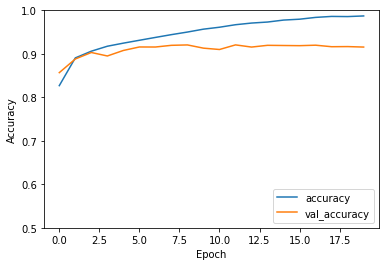

313/313 - 6s - loss: 0.3990 - accuracy: 0.9156 - 6s/epoch - 21ms/step


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(x_test_cnn, y_test_hor, verbose=2)

##3.6 Other experiments

cost after epoch 0: 1.949
cost after epoch 1: 1.709
cost after epoch 2: 1.667
cost after epoch 3: 1.649
cost after epoch 4: 1.637
cost after epoch 5: 1.628
cost after epoch 6: 1.621
cost after epoch 7: 1.616
cost after epoch 8: 1.610
cost after epoch 9: 1.605
cost after epoch 10: 1.601
cost after epoch 11: 1.598
cost after epoch 12: 1.595
cost after epoch 13: 1.590
cost after epoch 14: 1.589
cost after epoch 15: 1.585
cost after epoch 16: 1.582
cost after epoch 17: 1.581
cost after epoch 18: 1.579
cost after epoch 19: 1.576
cost after epoch 20: 1.573
cost after epoch 21: 1.571
cost after epoch 22: 1.569
cost after epoch 23: 1.567
cost after epoch 24: 1.566
test accuracy: 0.88
cost after epoch 0: 1.993
cost after epoch 1: 1.722
cost after epoch 2: 1.675
cost after epoch 3: 1.656
cost after epoch 4: 1.646
cost after epoch 5: 1.637
cost after epoch 6: 1.629
cost after epoch 7: 1.624
cost after epoch 8: 1.618
cost after epoch 9: 1.614
cost after epoch 10: 1.610
cost after epoch 11: 1.606
c

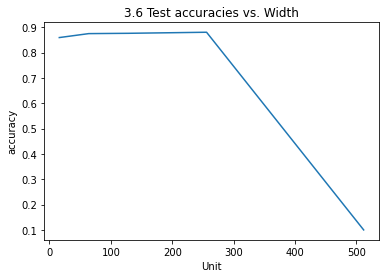

In [ ]:
# impact of width 

mlp3 = MLP(relu, drelu, 2, [128,20], 2, 0)
mlp3.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp3.predict(x_test_mlp)
acc1 = mlp3.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc1:.2f}")

mlp3 = MLP(relu, drelu, 2, [64,20], 2, 0)
mlp3.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp3.predict(x_test_mlp)
acc2 = mlp3.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc2:.2f}")

mlp3 = MLP(relu, drelu, 2, [16,20], 2, 0)
mlp3.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp3.predict(x_test_mlp)
acc3 = mlp3.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc3:.2f}")

mlp3 = MLP(relu, drelu, 2, [256,20], 2, 0)
mlp3.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp3.predict(x_test_mlp)
acc4 = mlp3.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc4:.2f}")

mlp3 = MLP(relu, drelu, 2, [512,20], 2, 0)
mlp3.fit(x_train_mlp, y_train_after, epoch=25, threshold=0.0001)
pred = mlp3.predict(x_test_mlp)
acc5 = mlp3.evaluate_acc(pred, y_test_after)
print(f"test accuracy: {acc5:.2f}")

x = [16, 64, 128, 256, 512]
y = [acc3, acc2, acc1, acc4, acc5]
plt.title("3.6 Test accuracies vs. Width")
plt.plot(x, y)
plt.xlabel('Unit')
plt.ylabel('accuracy')
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 activation_4 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 64)          51264     
                                                                 
 activation_5 (Activation)   (None, 4, 4, 64)          0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                  

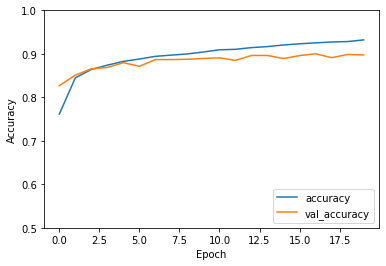

313/313 - 6s - loss: 0.3990 - accuracy: 0.9156 - 6s/epoch - 20ms/step


In [ ]:
# different stride in cnn 

model1 = models.Sequential()

#first set of CONV
model1.add(Conv2D(32, (5, 5), strides=(2, 2),padding="same", input_shape=(28,28,1)))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV
model1.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
model1.add(Activation('relu'))
model1.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))


model1.add(Flatten())
model1.add(Dense(128))
model1.add(Activation('relu'))

# softmax classifier
model1.add(Dense(10))
model1.add(Activation('softmax'))
model1.summary()

model1.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model1.fit(x_train_cnn, y_train_hor, validation_data=(x_test_cnn, y_test_hor), 
            batch_size=128, epochs=20, verbose=1)
test_loss_1, test_acc_1 = model1.evaluate(x_test_cnn,  y_test_hor, verbose=2)



model2 = models.Sequential()

#first set of CONV
model2.add(Conv2D(32, (5, 5), strides=(3, 3),padding="same", input_shape=(28,28,1)))
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV
model2.add(Conv2D(64, (5, 5), strides=(3, 3), padding="same"))
model2.add(Activation('relu'))
model2.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))


model2.add(Flatten())
model2.add(Dense(128))
model2.add(Activation('relu'))

# softmax classifier
model2.add(Dense(10))
model2.add(Activation('softmax'))
model2.summary()

model2.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history = model2.fit(x_train_cnn, y_train_hor, validation_data=(x_test_cnn, y_test_hor), 
            batch_size=128, epochs=20, verbose=1)
test_loss_2, test_acc_2 = model2.evaluate(x_test_cnn,  y_test_hor, verbose=2)







No handles with labels found to put in legend.


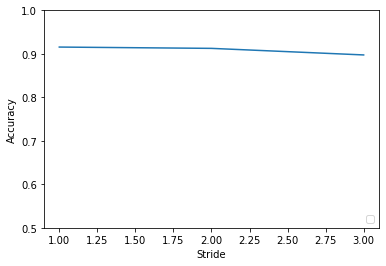

In [ ]:
x = [1,2,3]
y = [test_acc, test_acc_1, test_acc_2]
plt.plot(x, y)
plt.xlabel('Stride')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.show()

In [ ]:
# different training data size 

data = [1, 10, 1000, 10000]
cnn_accuracy = []
mlp_accuracy = []

for i in range(len(data)):
  # CNN
  history = model.fit(x_train_cnn[:data[i]], y_train_hor[:data[i]], validation_data=(x_test_cnn, y_test_hor), 
            batch_size=128, epochs=20, verbose=1)
  test_loss, test_acc = model.evaluate(x_test_cnn,  y_test_hor, verbose=2)
  print(f"cnn accuracy: {test_acc:.2f}")
  # MLP
  mlp3 = MLP(relu, drelu, 2, [128,20], 2, 0)
  mlp3.fit(x_train_mlp[:data[i]], y_train_after[:data[i]], epoch=20, threshold=0.0001)
  pred = mlp3.predict(x_test_mlp)
  acc1 = mlp3.evaluate_acc(pred, y_test_after)
  print(f"mlp accuracy: {acc1:.2f}")
  cnn_accuracy.append(test_acc)
  mlp_accuracy.append(acc1)

# CNN
history = model.fit(x_train_cnn, y_train_hor, validation_data=(x_test_cnn, y_test_hor), 
            batch_size=128, epochs=20, verbose=1)
test_loss, test_acc = model.evaluate(x_test_cnn,  y_test_hor, verbose=2)
print(f"cnn accuracy: {test_acc:.2f}")
cnn_accuracy.append(test_acc)
# MLP
mlp3 = MLP(relu, drelu, 2, [128,20], 2, 0)
mlp3.fit(x_train_mlp, y_train_after, epoch=20, threshold=0.0001)
pred = mlp3.predict(x_test_mlp)
acc1 = mlp3.evaluate_acc(pred, y_test_after)
mlp_accuracy.append(acc1)
print(f"mlp accuracy: {acc1:.2f}")

Epoch 1/20
1/1 [==============================] - 6s 6s/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 0.5145 - val_accuracy: 0.9220
Epoch 2/20
1/1 [==============================] - 6s 6s/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 0.5145 - val_accuracy: 0.9219
Epoch 3/20
1/1 [==============================] - 6s 6s/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 0.5146 - val_accuracy: 0.9219
Epoch 4/20
1/1 [==============================] - 6s 6s/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 0.5146 - val_accuracy: 0.9217
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 0.5147 - val_accuracy: 0.9217
Epoch 6/20
1/1 [==============================] - 6s 6s/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 0.5147 - val_accuracy: 0.9218
Epoch 7/20
1/1 [==============================] - 6s 6s/step - loss: 1.1921e-07 - accuracy: 1.0000 - val_loss: 0.5147 - val_accuracy: 0.9218
Epoch 8/20
1/

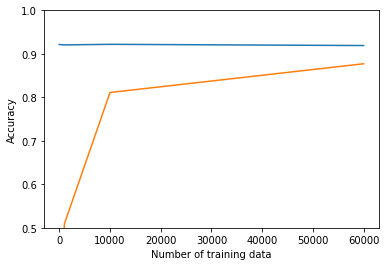

In [ ]:
x = [1, 10, 1000, 10000, 60000]
plt.plot(x, cnn_accuracy, label='cnn_accuracy')
plt.plot(x, mlp_accuracy, label = 'mlp_accuracy')
plt.xlabel('Number of training data')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.show()